# TP Module 9 : Optimisation des modèles

But de l'optimisation des modèles :

- Réduire la taille du modèle.
- Accélérer le temps d'inférence.
- Réduire la consommation énergétique du modèle.


Quelles sont les différentes façon d'optimiser une modèle ?

- Réduire sa précision numérique.
  - Les paramètres et fonctions d'activations d'un modèle sont le plus souvent représentés en `float32`. **Quantification**
- Toutes les opérations du graphe d'un modèle sont elles nécéssaires durant l'inférence ? **Fusion des couches**
- Tous les paramètres contribuent ils à la performance du modèle ? **Pruning**
- Améliorer les allers-retours entre GPU et CPU.

**Pruning-Elagage**

Une des première alternatives lors de l'optimisation des modèles et de se poser la question des paramètres (ie poids & biais). Tous les paramètres n'ont pas la même importance.

L'idée ici est qu'un réseau entraîné peut être réduit à un réseau plus petit en supprimant les poids inutiles. En pratique, cela signifie que les pondérations "inutiles" sont fixées à zéro. En mettant les pondérations inutiles à zéro, l'inférence ou la prédiction peut être accélérée.

De plus, les modèles élagués peuvent être compressés en modèles de taille plus petite, car des pondérations peu nombreuses entraînent des taux de compression plus élevés.

Dans le cas de modèle créés via Tensoflow, cela se fait via la librairie **Tensorflow model optimization**.


- Ref
  - https://colab.research.google.com/github/sayakpaul/Adventures-in-TensorFlow-Lite/blob/master/A_tale_of_quantization.ipynb#scrollTo=HHZ-SsZU5VAW
  - https://colab.research.google.com/github/sayakpaul/Adventures-in-TensorFlow-Lite/blob/master/Model_Pruning_in_Deep_Learning_with_tfmot.ipynb#scrollTo=cEDnyetVLTcM
  - https://colab.research.google.com/github/sayakpaul/Adventures-in-TensorFlow-Lite/blob/master/Custom_Image_Classification_EdgeTPU.ipynb#scrollTo=57GUpImAP7KC

- TF Lite

  - https://www.tensorflow.org/lite/performance/post_training_quantization

  - https://www.tensorflow.org/lite/performance/post_training_quant

  - https://www.tensorflow.org/lite/performance/post_training_quantization#dynamic_range_quantization

  - https://www.tensorflow.org/lite/performance/best_practices#profile_your_application_with_platform_specific_tools

  - https://www.tensorflow.org/lite/performance/post_training_integer_quant

- Model Optimization/Pruning

  - https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras#overview

  - https://www.tensorflow.org/model_optimization/api_docs/python/tfmot

  - https://www.tensorflow.org/model_optimization/api_docs/python/tfmot/sparsity/keras/ConstantSparsity

   -https://www.tensorflow.org/model_optimization/api_docs/python/tfmot/sparsity/keras/PruningSchedule

  - https://www.tensorflow.org/model_optimization/guide/quantization/training_comprehensive_guide

   -https://www.tensorflow.org/model_optimization/guide/pruning/comprehensive_guide#prune_whole_model_sequential_and_functional

 - https://www.tensorflow.org/model_optimization/guide/quantization/training

 - https://tensorflow.google.cn/model_optimization/guide/pruning/pruning_with_keras

- Save/Load

  - https://www.tensorflow.org/tutorials/keras/save_and_load













## **Import libs**

In [ ]:
import tensorflow as tf
from tensorflow import keras

print(f'tf : {tf.__version__}')
print(f'keras : {keras.__version__}')

import pandas as pd
import numpy as np
import random
import os
import datetime

# freeze de l'aléatoire, pour avoir des expériences reproductibles.
RANDOM_SEED = 42

os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_seed(RANDOM_SEED)

tf : 2.3.0
keras : 2.4.0


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split

from imutils import paths
import matplotlib.pyplot as plt
import shutil
import time
import cv2

In [ ]:
!nvidia-smi

Wed Aug 26 11:53:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
comp = pd.DataFrame()
comp['model'] = []
comp['précision'] = []

## Import du dataset

In [ ]:
# Gather Flowers-17 dataset
data_root = tf.keras.utils.get_file(
  "/content/flower_photos", "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz",
   untar=True)

228818944/228813984 [==============================] - 2s 0us/step


In [ ]:
# Untar the dataset
!tar -xvf flower_photos.tar.gz

In [ ]:
# All the paths of the flowers
ALL_IMG_PATHS = list(paths.list_images("flower_photos"))
ALL_IMG_PATHS[:5]

['flower_photos/dandelion/19626311985_58f1a79da3.jpg',
 'flower_photos/dandelion/479495978_ee22cf05be.jpg',
 'flower_photos/dandelion/7401173270_ebaf04c9b0_n.jpg',
 'flower_photos/dandelion/4588529727_4a79c61577.jpg',
 'flower_photos/dandelion/144686365_d7e96941ee_n.jpg']

### Visualisation

Une fois que les données ont été téléchargées, voyons un peu à quoi ressemble notre dataset.

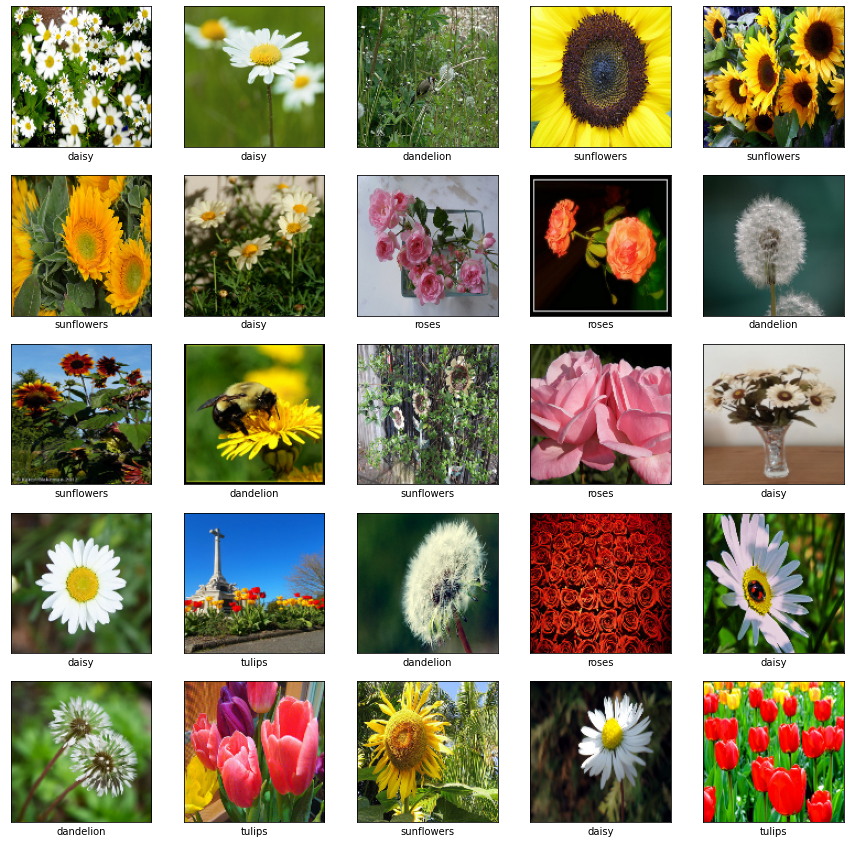

In [ ]:
# Visualize images
plt.figure(figsize=(15,15))
for i in range(25):
    image_path = np.random.choice(ALL_IMG_PATHS)
    image = plt.imread(image_path)
    image = cv2.resize(image, (128, 128))
    # you might want to verify the labels before 
    # you put this to use
    label = image_path.split("/")[1]
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(image)
    plt.xlabel(label)
plt.show()

### Train, val, test datasets

Comme d'habitude, nous allons séparer notre dataset d'origine en 3 jeux de données différents.

In [ ]:
flower_train, flower_val = train_test_split(ALL_IMG_PATHS, test_size=0.20, random_state=RANDOM_SEED)
flower_test, flower_val = train_test_split(flower_val, test_size=0.5, random_state=RANDOM_SEED)
print(f'images in train : {len(flower_train)}, images in val : {len(flower_val)}, images in test {len(flower_test)}')

images in train : 2936, images in val : 367, images in test 367


In [ ]:
dic = {b'daisy': 0, b'dandelion': 1, b'roses': 2, b'sunflowers': 3, b'tulips': 4}
label_train = [dic[tf.strings.split(filename, '/')[1].numpy()] for filename in flower_train]
label_val = [dic[tf.strings.split(filename, '/')[1].numpy()] for filename in flower_val]
label_test = [dic[tf.strings.split(filename, '/')[1].numpy()] for filename in flower_test]
print(f'labels in train : {len(label_train)}, labels in val : {len(label_val)}, labels in test {len(label_test)}')

labels in train : 2936, labels in val : 367, labels in test 367


In [ ]:
NUM_CLASSES = 5
AUTOTUNE = tf.data.experimental.AUTOTUNE

def parse_image(filename,label):
  # convert the label to one-hot encoding
  label = tf.one_hot(label, NUM_CLASSES)
  
  #decode image
  image = tf.io.read_file(filename)
  #Don't use tf.image.decode_image, or the output shape will be undefined
  image = tf.image.decode_jpeg(image)
  #This will convert to float values in [0, 1]
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [224, 224])
  return image, label
  
def train_preprocess(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)

  return image, label

def create_train_dataset(features, labels, batch=32, repet=1, prefetch=1):
  dataset = tf.data.Dataset.from_tensor_slices((features,labels))
  dataset = dataset.shuffle(len(features), seed=RANDOM_SEED)
  dataset = dataset.repeat(repet)
  dataset = dataset.map(parse_image, num_parallel_calls=AUTOTUNE)
  dataset = dataset.map(train_preprocess, num_parallel_calls=AUTOTUNE)
  dataset = dataset.batch(batch)
  dataset = dataset.prefetch(prefetch)
  return dataset

def create_val_dataset(features, labels, batch=32, repet=1, prefetch=1):
  dataset = tf.data.Dataset.from_tensor_slices((features,labels))
  dataset = dataset.shuffle(len(features), seed=RANDOM_SEED)
  dataset = dataset.repeat(repet)
  dataset = dataset.map(parse_image, num_parallel_calls=AUTOTUNE)
  dataset = dataset.batch(batch)
  dataset = dataset.prefetch(prefetch)
  return dataset

In [ ]:
ds_train = create_train_dataset(flower_train, label_train)
ds_val = create_val_dataset(flower_val, label_val)
ds_test = create_val_dataset(flower_test, label_test)

## Construction du modèle & entraînement du modèle

### Construction

Pour nous simplifier la tâache, nous allons utiliser un modèle pré-entraîné. La famille des modèles *MobileNet* sont des modèles déstinés à êêtre déployés sur des environnements où les ressources sont contraintes : RPi, smartphone, MCU.

Nous allons utiliser MobileNetV2 comme base convolutive de notre modèle, les poids provenant d'imagenet.

In [ ]:
# Load the MobileNetV2 model but exclude the classification layers
conv_base = MobileNetV2(weights="imagenet", 
                        include_top=False,
                        input_shape=(224, 224, 3))

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
def get_training_model():
    # We are fine-tuning the extractor model
    conv_base.trainable = True
    # Construct the head of the model that will be placed on top of the
    # the base model
    class_head = conv_base.output
    class_head = GlobalAveragePooling2D()(class_head)
    class_head = Dense(512, activation="relu")(class_head)
    class_head = Dropout(0.5)(class_head)
    class_head = Dense(5, activation="softmax")(class_head)

    # Create the new model
    classifier = Model(inputs=conv_base.input, outputs=class_head)

    # Compile and return the model
    classifier.compile(loss="categorical_crossentropy", 
                          optimizer="adam",
                          metrics=["accuracy"])

    return classifier

### Entraînement

Une des techniques que nous n'avons pas encore évoquer ici lors de l'utilisation de modèles pré-entrainés concerne le choix du taux d'apprentissage.

Utiliser un modèle pré-entraîné permet la plupart du temps de raccourcir la temps nécéssaire à l'entraînement du modèle sur notre propre dataset.

Cependant il faut comprendre une chose, les poids "optimaux" chargés lorsque l'on utilise un modèle pré-entrainé **ne sont pas forcément optimaux pour notre dataset**. Si le minimum obtenu par la fonction de perte $\mathcal{L}_{\vartheta}$ "est trop profond", utiliser un taux d'apprentissage très petit dès le départ ne nous en fera pas sortir. 

Les étapes d'échauffement (warm-up training) ne sont que quelques mises à jour avec un taux d'apprentissage croissant au début de la formation. Après cet échauffement, vous utilisez le taux d'apprentissage régulier pour entraîner votre modèle à la convergence.

L'idée que cela aide votre réseau à s'adapter lentement et intuitivement aux données : des données ayant des distributions proches devraient avoir des optimum proches. Cependant, en théorie, la principale raison des étapes de mise en route est de permettre aux optimiseurs adaptatifs (par exemple, Adam, RMSProp, ...) de calculer des statistiques correctes des gradients. Par conséquent, une période d'échauffement n'a pas beaucoup de sens lors d'un entraînement avec un SGD simple.

In [ ]:
# LR schedule configuration
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

Détaillons la configuration suivante.

- Notre échauffement se fera sur $\text{rampup_epochs} = 5$ époques, avec un taux d'apprentissage de départ égal à $\text{start_lr} = 0.00001$.
- Sur les $5$ première époques, on a une croissance linéaire du taux d'apprentissage :

$$\text{lr} = \frac{(\text{max_lr} - \text{start_lr})}{\text{rampup_epochs}} \cdot \text{epoch} + \text{start_lr}$$


$$\text{lr} = \frac{0,00004}{5} \cdot \text{epoch} + 0,00001$$

- Une fois arrivé à la $5$ époque, on peut maintenir ce taux d'apprentissage pendant $\text{sustain_epochs}$. Ici on a choisi de ne pas le maintenir.

- Dès la $6$-ième époque, on applique un taux de décroissance exponentiel, comme pour un entraînement classique.

In [ ]:
# LR schedule
def lrfn(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

1e-05 1.0002177807148294e-05


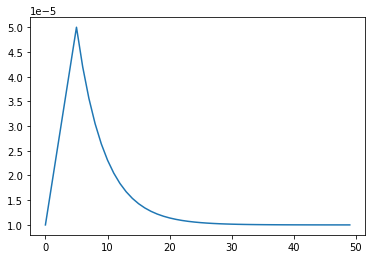

In [ ]:
# How does the LR schedule looks like?
rng = [i for i in range(50)]
y = [lrfn(x) for x in rng]
plt.plot(rng, [lrfn(x) for x in rng])
print(y[0], y[-1])

In [ ]:
# Train the model
flower_model = get_training_model()
start = time.time()
history = flower_model.fit(ds_train,
                           validation_data=ds_val,
                           epochs=10,
                           callbacks=[lr_callback])
print("Total training time: ",time.time()-start)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/10
92/92 [==============================] - 36s 395ms/step - loss: 1.6359 - accuracy: 0.3253 - val_loss: 1.2309 - val_accuracy: 0.5150

Epoch 00002: LearningRateScheduler reducing learning rate to 1.8000000000000004e-05.
Epoch 2/10
92/92 [==============================] - 34s 374ms/step - loss: 1.0201 - accuracy: 0.6001 - val_loss: 0.7831 - val_accuracy: 0.7057

Epoch 00003: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
Epoch 3/10
92/92 [==============================] - 35s 376ms/step - loss: 0.6289 - accuracy: 0.7749 - val_loss: 0.5516 - val_accuracy: 0.8011

Epoch 00004: LearningRateScheduler reducing learning rate to 3.4000000000000007e-05.
Epoch 4/10
92/92 [==============================] - 34s 374ms/step - loss: 0.4512 - accuracy: 0.8379 - val_loss: 0.4492 - val_accuracy: 0.8447

Epoch 00005: LearningRateScheduler reducing learning rate to 4.2000000000000004e-05.
Epoch 5/10
92/9

#### Evaluation

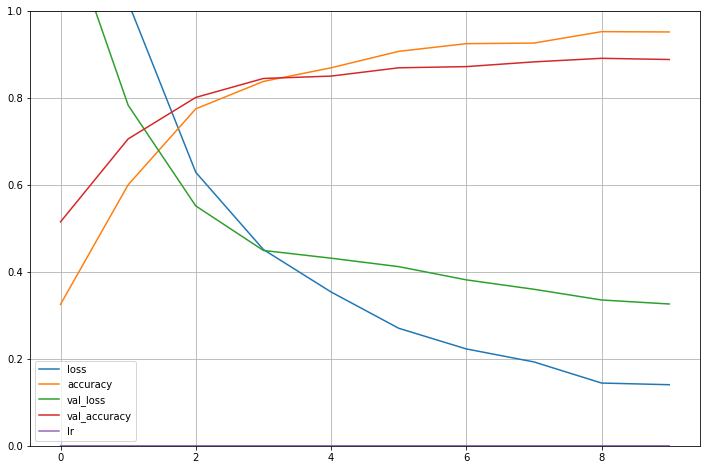

In [ ]:
pd.DataFrame(history.history).plot(figsize=(12,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
_, accuracy = flower_model.evaluate(ds_test)

comp = comp.append({'model': 'unoptim_model', 'précision' : accuracy}, ignore_index=True)
print(comp)

12/12 [==============================] - 1s 78ms/step - loss: 0.2286 - accuracy: 0.9155
           model  précision
0  unoptim_model   0.915531


### Sauvegarde

Pour convertir un modèle, que ce soit avec TF Lite ou avec TensorRT, on doit le sauvegarder sous la format `SavedModel` qui est le format standard de TensorFlow. La méthode classique où l'on utilise le format `.h5` est elle propre à `tf.keras`.

In [ ]:
# Unoptimized (SavedModel format)
flower_model.save("base_model/flower_model_no_op")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: base_model/flower_model_no_op/assets


Vérifions la taille du modèle.

In [ ]:
# Check size
!du --all -h base_model/flower_model_no_op

40K	base_model/flower_model_no_op/variables/variables.index
34M	base_model/flower_model_no_op/variables/variables.data-00000-of-00001
34M	base_model/flower_model_no_op/variables
4.0K	base_model/flower_model_no_op/assets
3.6M	base_model/flower_model_no_op/saved_model.pb
37M	base_model/flower_model_no_op


Charger un modèle se fait de la même façon, que l'on utilise le format `SavedModel` ou `.h5`.

In [ ]:
flower_model = tf.keras.models.load_model('base_model/flower_model_no_op')

# Check its architecture
flower_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

## Pruning/Elagage

Comme dit précédemment, pour pouvoir appliquer l'élagage pour optimiser le modèle, on va avoir besoin de la librairie **tensorflow-model-optimization**.

In [ ]:
!pip install -q tensorflow-model-optimization

     |████████████████████████████████| 174kB 2.8MB/s 


In [ ]:
import tensorflow_model_optimization as tfmot

### Elagage d'un modèle déjà entraîné avec un entraînement supplémentaire

Pour chaque couche choisie pour être élaguée, un masque binaire est construit de la même dimension que le tenseur de poids de la couche et il détermine quels poids participent à l'étape de feedforward. 

Les poids sont ordonnés suivant leur valeurs absolues et l'on masque les poids de plus petite valeur absolue jusqu'à ce qu'un certain seuil $s \in ]0,1[$ de valeurs masquées soit atteint.

Lors de l'étape de rétropropagation, le gradient passant par le masque binaire seuls les poids non masquées sont mis à jour.

Au fur et à mesure que le taux d'apprentissage baisse, il a été observé que les poids élagués alors que ce dernier est très petit sont difficilement compensés par les autres. Il est donc important de choisir le bon LRD et de ne pas élaguer tout le long de l'entraînement. 

In [ ]:
import tempfile

target_sparsity = 0.5 # A scalar float representing the target sparsity value. 
begin_step = 0 # Step at which to begin pruning. 
end_step =  -1 # Step at which to end pruning. -1 by default. -1 implies continuing to prune till the end of training. 
frequency = 1 # Only apply pruning every frequency steps. 
epochs = 4 # Number of epochs we'll fine tune with pruning

# Define pruning schedule
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(
          target_sparsity=target_sparsity,
          begin_step=begin_step,
          end_step=end_step,
          frequency=frequency
      )
}

Détaillons.

- Elaguer signifie que nous souhaitons avoir uniquement un certain nombre/pourcentage de poids non nuls, ce pourcentage est défini par notre variable `target_sparsity`, ici fixée à $0.5$. A la fin de l'entraînement, nous aurons donc $50\%$ des poids des couches élaguées (couches denses, convolutives) qui seront nuls.

- De par l'observation donnée au dessus, nous n'allons pas élaguer sur toute la durée de l'entraînement, mais seulement sur les `epochs = 4` premières époques de l'entraînement. Notre dataset étant relativement petit, nous allons élaguer à chaque étape (`frequency`) des ces époques, de la première étape (`begin_step`), à la dernière de l'époque $4$ (`end_step`). 

- Chacune de ces variables sert de paramètre à la fonction `tfmot.sparsity.keras.ConstantSparsity`, qui définit comment va se faire l'élagage. Ici on a choisi un élagage constant (`ConstantSparsity`) sur les étapes et époques, ce qui signifie qu'à chaque étape on choisira la moitié haute des poids : **ceux de plus haute magnitude**, et que les autres seront mis à zéro.

D'autres techniques d'élagage existe, comme la décroissance polynomiale `PolynomialDecay` : https://www.tensorflow.org/model_optimization/api_docs/python/tfmot/sparsity/keras/PolynomialDecay

In [ ]:
original_model = tf.keras.models.load_model('base_model/flower_model_no_op')
model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(original_model,
                                                             **pruning_params)

# prune_low_magnitude requires a recompile.
model_for_pruning.compile(optimizer='adam',
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

# Train the model.
logdir = tempfile.mkdtemp()
callbacks = [lr_callback,
             tfmot.sparsity.keras.UpdatePruningStep(),
             tfmot.sparsity.keras.PruningSummaries(log_dir=logdir)]

Une fois que la méthode d'élagage a été correctement définie, le modèle est alors envoyé dans la fonction `tfmot.sparsity.keras.prune_low_magnitude(original_model, **pruning_params)` afin de créer les masques binaires qui serviront à l'élagage.

Des couches ayant été rajoutées, il est nécéssaire de recompiler le modèle

```python
# prune_low_magnitude requires a recompile.
model_for_pruning.compile(optimizer='adam',
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])
```

In [ ]:
start = time.time()
history = model_for_pruning.fit(ds_train,
                                validation_data=ds_val,
                                epochs=10,
                                callbacks=callbacks)
print("Total training time: ",time.time()-start)

Une fois l'entraînement terminé, on peut vérifier que toutes les couches pouvant être élaguées ont bien $50\%$ des leur poids qui sont nuls avec l'aide de la fonction suivante.

In [ ]:
#Sanity check to see if the sparsity threshold is reached
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

def get_sparsity(weights):
    return 1.0 - np.count_nonzero(weights) / float(weights.size)

def test_sparsity(model, target_sparsity):
    for layer in model.layers:
        if isinstance(layer, pruning_wrapper.PruneLowMagnitude):
            for weight in layer.layer.get_prunable_weights():
                print(np.allclose(
                    target_sparsity, get_sparsity(tf.keras.backend.get_value(weight)), 
                    rtol=1e-6, atol=1e-6))

In [ ]:
test_sparsity(model_for_pruning, target_sparsity=0.5)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


**IMPORTANT** : On a rajouté des couches (les masques binaires) lors du lancement de l'entraînement, il est nécéssaire des les retirer pour pouvoir profiter du modèle par la suite.

In [ ]:
# Once a model has been pruned to required sparsity, this method can be used to restore the original model with the sparse weights.

pruned_model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

Une fois que le modèle a été élagué avec les critères voulus, il est nécéssaire de le recompiler pour pouvoir l'utiliser.

In [ ]:
pruned_model_for_export.compile(optimizer='adam',
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

_, accuracy =  pruned_model_for_export.evaluate(ds_test)

comp = comp.append({'model': 'pruned_model', 'précision' : accuracy}, ignore_index=True)
print(comp)

12/12 [==============================] - 1s 94ms/step - loss: 0.2757 - accuracy: 0.9046
           model  précision
0  unoptim_model   0.915531
1   pruned_model   0.904632


In [ ]:
# Checkpoint: saving the optimizer is necessary (include_optimizer=True is the default).
pruned_model_for_export.save('pruned_model', include_optimizer=True)

# Deserialize model and load a pruned model.
with tfmot.sparsity.keras.prune_scope():
  loaded_model = tf.keras.models.load_model('pruned_model')

#loaded_model.summary()

On peut alors voir que le modèle a bien $50\%$ de ses poids qui sont nuls, sur les couches qui sont les plus impactantes : les noyaux de convolution et les couches denses.

In [ ]:
for i, w in enumerate(loaded_model.get_weights()):
    print(
        f"{loaded_model.weights[i].name} -- Total: {w.size}, Zeros: {np.sum(w == 0) / w.size * 100:.2f}%"
        )

Conv1/kernel:0 -- Total: 864, Zeros: 50.00%
bn_Conv1/gamma:0 -- Total: 32, Zeros: 0.00%
bn_Conv1/beta:0 -- Total: 32, Zeros: 0.00%
bn_Conv1/moving_mean:0 -- Total: 32, Zeros: 0.00%
bn_Conv1/moving_variance:0 -- Total: 32, Zeros: 0.00%
expanded_conv_depthwise/depthwise_kernel:0 -- Total: 288, Zeros: 0.00%
expanded_conv_depthwise_BN/gamma:0 -- Total: 32, Zeros: 0.00%
expanded_conv_depthwise_BN/beta:0 -- Total: 32, Zeros: 0.00%
expanded_conv_depthwise_BN/moving_mean:0 -- Total: 32, Zeros: 0.00%
expanded_conv_depthwise_BN/moving_variance:0 -- Total: 32, Zeros: 0.00%
expanded_conv_project/kernel:0 -- Total: 512, Zeros: 50.00%
expanded_conv_project_BN/gamma:0 -- Total: 16, Zeros: 0.00%
expanded_conv_project_BN/beta:0 -- Total: 16, Zeros: 0.00%
expanded_conv_project_BN/moving_mean:0 -- Total: 16, Zeros: 0.00%
expanded_conv_project_BN/moving_variance:0 -- Total: 16, Zeros: 0.00%
block_1_expand/kernel:0 -- Total: 1536, Zeros: 50.00%
block_1_expand_BN/gamma:0 -- Total: 96, Zeros: 0.00%
block_1_e

La précision est sensiblement la même, mais la taille du modèle a été divisée par deux.

In [ ]:
# Check size
!du --all -h pruned_model/

20K	pruned_model/variables/variables.index
12M	pruned_model/variables/variables.data-00000-of-00001
12M	pruned_model/variables
4.0K	pruned_model/assets
3.2M	pruned_model/saved_model.pb
15M	pruned_model/


### Modèle initialisé, élagage et entraînement from scratch

In [ ]:
target_sparsity = 0.5 
begin_step = 0
end_step =  -1 
frequency = 5

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(
          target_sparsity=target_sparsity,
          begin_step=begin_step,
          end_step=end_step,
          frequency=frequency
      )
}

model_blank = get_training_model()
pruning_from_scratch = tfmot.sparsity.keras.prune_low_magnitude(model_blank, 
                                                                **pruning_params)

# `prune_low_magnitude` requires a recompile.
pruning_from_scratch.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model.
logdir = tempfile.mkdtemp()
callbacks = [lr_callback,
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=logdir)]


start = time.time()
history = pruning_from_scratch.fit(ds_train,
                                   validation_data=ds_val,
                                   epochs=10,
                                   callbacks=callbacks)
print("Total training time: ",time.time()-start)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/10
92/92 [==============================] - 67s 730ms/step - loss: 1.5799 - accuracy: 0.3382 - val_loss: 1.6377 - val_accuracy: 0.2534

Epoch 00002: LearningRateScheduler reducing learning rate to 1.8000000000000004e-05.
Epoch 2/10
92/92 [==============================] - 63s 688ms/step - loss: 0.9193 - accuracy: 0.6649 - val_loss: 1.4945 - val_accuracy: 0.3678

Epoch 00003: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
Epoch 3/10
92/92 [==============================] - 63s 688ms/step - loss: 0.5380 - accuracy: 0.8290 - val_loss: 1.2798 - val_accuracy: 0.4659

Epoch 00004: LearningRateScheduler reducing learning rate to 3.4000000000000007e-05.
Epoch 4/10
92/92 [==============================] - 63s 689ms/step - loss: 0.3824 - accuracy: 0.8743 - val_loss: 1.0480 - val_accuracy: 0.6076

Epoch 00005: LearningRateScheduler reducing learning rate to 4.2000000000000004e-05.
Epoch 5/10
92/9

In [ ]:
for i, w in enumerate(pruning_from_scratch.get_weights()):
    print(
        f"{pruning_from_scratch.weights[i].name} -- Total: {w.size}, Zeros: {np.sum(w == 0) / w.size * 100:.2f}%"
        )

prune_low_magnitude_Conv1_pad/pruning_step:0 -- Total: 1, Zeros: 0.00%
Conv1/kernel:0 -- Total: 864, Zeros: 50.00%
prune_low_magnitude_Conv1/mask:0 -- Total: 864, Zeros: 50.00%
prune_low_magnitude_Conv1/threshold:0 -- Total: 1, Zeros: 0.00%
prune_low_magnitude_Conv1/pruning_step:0 -- Total: 1, Zeros: 0.00%
bn_Conv1/gamma:0 -- Total: 32, Zeros: 0.00%
bn_Conv1/beta:0 -- Total: 32, Zeros: 0.00%
bn_Conv1/moving_mean:0 -- Total: 32, Zeros: 0.00%
bn_Conv1/moving_variance:0 -- Total: 32, Zeros: 0.00%
prune_low_magnitude_bn_Conv1/pruning_step:0 -- Total: 1, Zeros: 0.00%
prune_low_magnitude_Conv1_relu/pruning_step:0 -- Total: 1, Zeros: 0.00%
expanded_conv_depthwise/depthwise_kernel:0 -- Total: 288, Zeros: 0.00%
prune_low_magnitude_expanded_conv_depthwise/pruning_step:0 -- Total: 1, Zeros: 0.00%
expanded_conv_depthwise_BN/gamma:0 -- Total: 32, Zeros: 0.00%
expanded_conv_depthwise_BN/beta:0 -- Total: 32, Zeros: 0.00%
expanded_conv_depthwise_BN/moving_mean:0 -- Total: 32, Zeros: 0.00%
expanded_con

In [ ]:
test_sparsity(pruning_from_scratch, target_sparsity=0.5)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
pruned_model_scratch_for_export = tfmot.sparsity.keras.strip_pruning(pruning_from_scratch)

In [ ]:
pruned_model_scratch_for_export.compile(optimizer='adam',
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

_, accuracy =  pruned_model_scratch_for_export.evaluate(ds_test)

comp = comp.append({'model': 'pruned_model_from_scratch', 'précision' : accuracy}, ignore_index=True)
print(comp)

12/12 [==============================] - 1s 94ms/step - loss: 0.2918 - accuracy: 0.8883
                       model  précision
0              unoptim_model   0.915531
1               pruned_model   0.904632
2  pruned_model_from_scratch   0.888283


In [ ]:
# Checkpoint: saving the optimizer is necessary (include_optimizer=True is the default).
pruned_model_scratch_for_export.save('pruned_model_from_scratch', include_optimizer=True)

# Deserialize model and load a pruned model.
with tfmot.sparsity.keras.prune_scope():
  loaded_model = tf.keras.models.load_model('pruned_model_from_scratch')

#loaded_model.summary()

INFO:tensorflow:Assets written to: pruned_model_from_scratch/assets


In [ ]:
# Check size
!du --all -h pruned_model_from_scratch/

20K	pruned_model_from_scratch/variables/variables.index
12M	pruned_model_from_scratch/variables/variables.data-00000-of-00001
12M	pruned_model_from_scratch/variables
4.0K	pruned_model_from_scratch/assets
3.2M	pruned_model_from_scratch/saved_model.pb
15M	pruned_model_from_scratch/


In [ ]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

print(f"Size of gzipped pruned model trained from scratch: {get_gzipped_model_size('pruned_model_from_scratch/saved_model.pb')/1e6:.2f} Mb")

Size of gzipped pruned model trained from scratch: 0.24 Mb
